#### Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
 
import numpy as np
import matplotlib
import statsmodels.api as sm


matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
df = pd.read_csv("/Users/ana/ironhack_coding/projects/final_project/final-project/datasets/instagram_topics.csv",
                       parse_dates = ["Date"])

# only relevant columns and data
data = df.groupby(["Date", "Dominant_Topic"]).size().reset_index()

#tweaking new dataframe
data['Date'] = [d.date() for d in data['Date']]
data.rename(columns = {0:"no_posts"}, inplace= True)
data = data.sort_values(by="Date", ascending = False)

In [3]:
data.head()

,Date,Dominant_Topic,no_posts
14399,2020-03-19,12.0,1
14261,2020-03-19,0.0,1
14272,2020-03-19,6.0,1
14271,2020-03-19,0.0,1
14270,2020-03-19,13.0,1


In [4]:
data.dtypes # it should be dastetime ?

Date               object
Dominant_Topic    float64
no_posts            int64
dtype: object

### ARIMA Model



##### What is Arima?
ARIMA, short for ‘AutoRegressive Integrated Moving Average’, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

### topic 0 - the benefits of certain foods

#### Preparing the data

In [5]:
test = data[data.Dominant_Topic == 0.0]
test.index = test["Date"] # index to date for time series analysis
test = test.groupby(test.index).agg({"no_posts":sum})



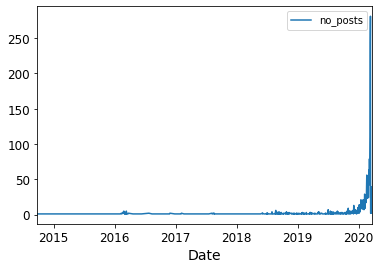

In [6]:
test.plot()


In [7]:
# dealing with NAN - > maybe 0 values
test.isna().sum()

no_posts    0
dtype: int64

In [8]:
test.isnull().sum()

no_posts    0
dtype: int64

In [9]:
# no zero values
test[test.no_posts == 0]

,no_posts
Date,


In [10]:
test.index = pd.to_datetime(test.index)
test.index




DatetimeIndex(['2014-09-22', '2015-09-15', '2015-09-24', '2015-11-15',
               '2015-12-03', '2015-12-13', '2016-02-05', '2016-02-10',
               '2016-02-13', '2016-02-23',
               ...
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17',
               '2020-03-18', '2020-03-19'],
              dtype='datetime64[ns]', name='Date', length=527, freq=None)

In [11]:
# there are missing dates, dealing with it:
idx = pd.date_range('2016-07-24', '2020-03-12')

test = test.reindex(idx, fill_value=0)



In [12]:
# only last three months


test = test.loc["2019-12-1" : "2020-3-12"]
test.head()


,no_posts
2019-12-01,1
2019-12-02,3
2019-12-03,13
2019-12-04,3
2019-12-05,2


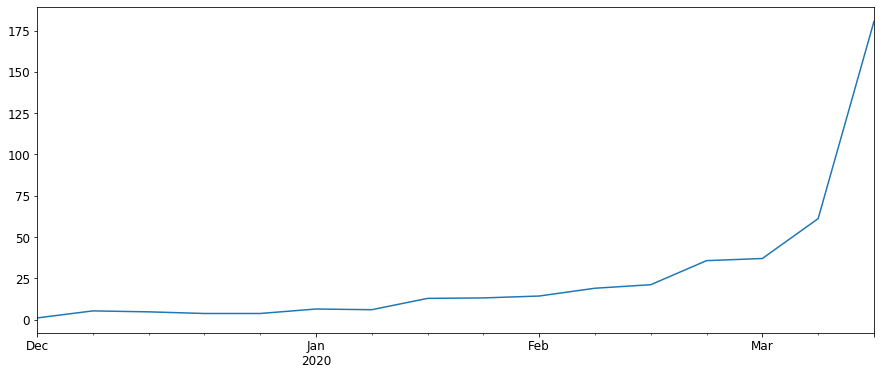

In [13]:
test['no_posts'].resample('W').mean().plot(figsize=(15, 6))

y = test['no_posts'].resample('W').mean()



In [14]:
from statsmodels.tsa.stattools import adfuller
#checking if the series is stationary

result = adfuller(y, autolag = "AIC")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: 5.054441
p-value: 1.000000


The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.



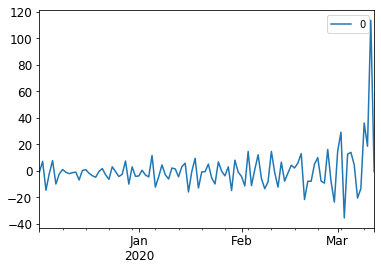

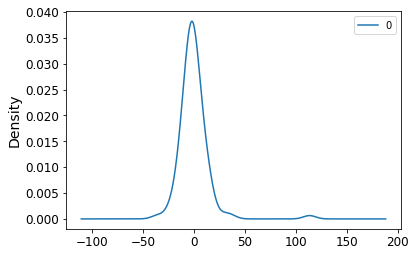

                0
count  102.000000
mean    -0.008598
std     15.267976
min    -35.700875
25%     -6.510875
50%     -1.229439
75%      4.291914
max    113.490022


In [15]:
from statsmodels.tsa.arima_model import ARIMA
 
model = ARIMA(test, order=(5,1,0))
model_fit = model.fit(disp=0)

#print(model_fit.summary())

# plot residual errors: residual of an observed value is 
# the difference between the observed value and the estimated value of the quantity of interest 
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

The residual errors should have near zero mean and uniform variance. 

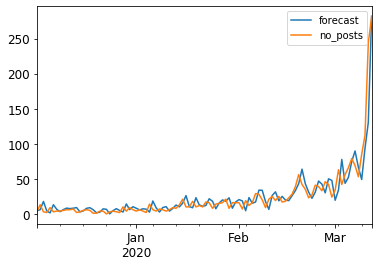

In [16]:
model_fit.plot_predict(dynamic=False)
plt.show()

## Forecasting

Test MSE: 1140.925


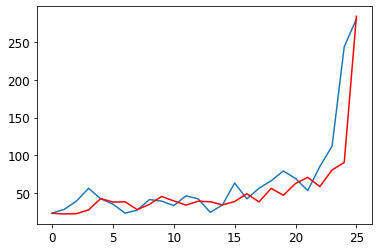

In [17]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
 
X = test.values
size = int(len(X) * 0.75)   # Split percentage

train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t] # you forecast the next "point" continuosly
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# this is just the test, the train preceeds it

Mean absolute error -  diz a diferenca real, melhor que o mse
o  valor deve ser o minimo possivel



In [18]:
error = mean_absolute_error(test, predictions)

In [19]:
print(error)

17.326406008571308


In [20]:
# em termos de resultados,
# a previsao é x mais ou menos o mean_absolute_error

## Forecast for other topics

### Topic 11 - Recipes

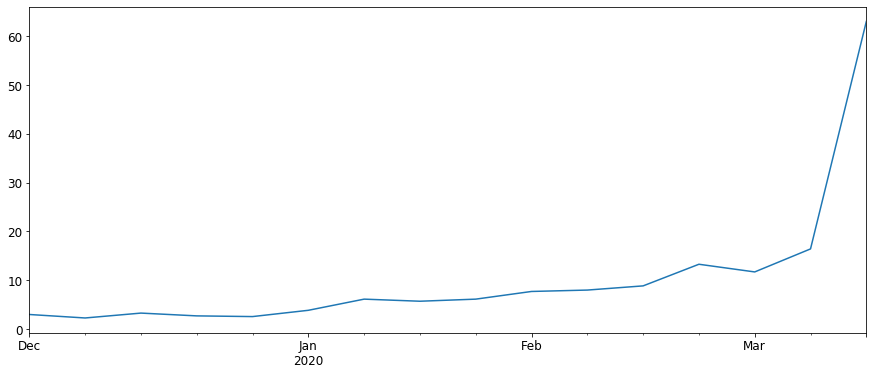

In [34]:
topic_11 = data[data.Dominant_Topic == 11.0]
topic_11.index = topic_11["Date"] # index to date for time series analysis

#grouping by type of tomic and summing number of posts
topic_11 = topic_11.groupby(topic_11.index).agg({"no_posts":sum})

#changing index to datetime
topic_11.index = pd.to_datetime(topic_11.index)


#filling out dates when these don't exist
idx = pd.date_range('2016-07-24', '2020-03-12')
topic_11 = topic_11.reindex(idx, fill_value=0)

#selecting only last three months
topic_11 = topic_11.loc["2019-12-1" : "2020-3-12"]

#plotting 
topic_11['no_posts'].resample('W').mean().plot(figsize=(15, 6))

#setting up y for future forecast
y = topic_11['no_posts'].resample('W').mean()


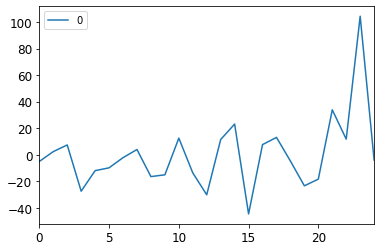

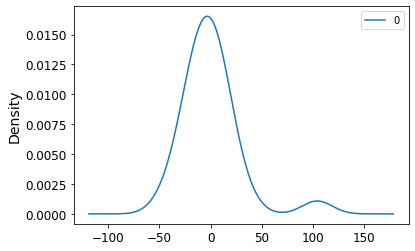

                0
count   25.000000
mean     0.192808
std     27.993501
min    -44.531310
25%    -15.098217
50%     -3.992989
75%     11.466241
max    104.300136


In [35]:
from statsmodels.tsa.arima_model import ARIMA
 
model = ARIMA(test, order=(5,1,0))
model_fit = model.fit(disp=0)

#print(model_fit.summary())

# plot residual errors: residual of an observed value is 
# the difference between the observed value and the estimated value of the quantity of interest 
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

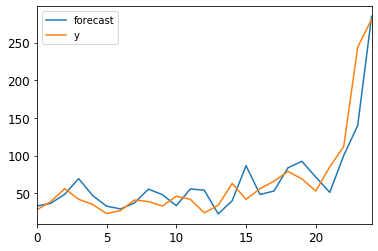

In [36]:
model_fit.plot_predict(dynamic=False)
plt.show()

topic_11 MSE: 161.085


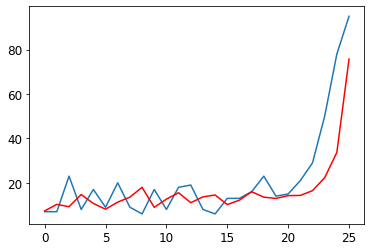

In [37]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
 
X = topic_11.values
size = int(len(X) * 0.75)   # Split percentage

train, topic_11 = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(topic_11)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = topic_11[t] # you forecast the next "point" continuosly
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(topic_11, predictions)
print('topic_11 MSE: %.3f' % error)
# plot
plt.plot(topic_11)
plt.plot(predictions, color='red')
plt.show()

# this is just the topic_11, the train preceeds it

In [38]:
 mean_absolute_error(test, predictions)
    
    

48.48578517870705

### Topic 1 - inspirational live, love, etc

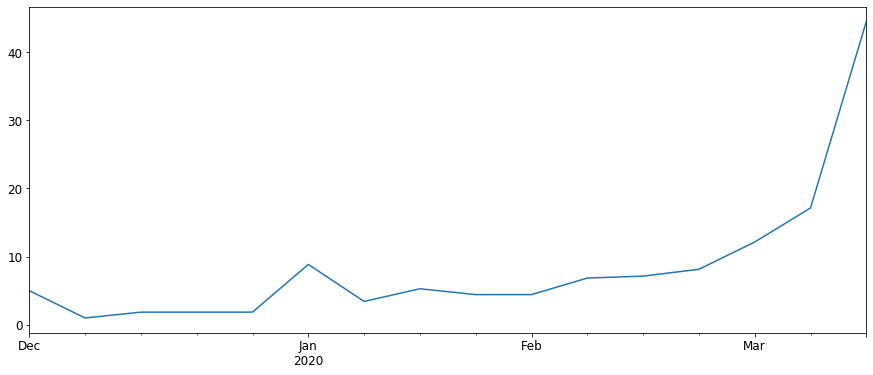

In [43]:
topic_1 = data[data.Dominant_Topic == 1.0]
topic_1.index = topic_1["Date"] # index to date for time series analysis

#grouping by type of tomic and summing number of posts
topic_1 = topic_1.groupby(topic_1.index).agg({"no_posts":sum})

#changing index to datetime
topic_1.index = pd.to_datetime(topic_1.index)

#dropping Nans
topic_1.dropna(axis=0, inplace = True)

#filling out dates when these don't exist
idx = pd.date_range('2016-07-24', '2020-03-12')
topic_1 = topic_1.reindex(idx, fill_value=0)

#selecting only last three months
topic_1 = topic_1.loc["2019-12-1" : "2020-3-12"]

#plotting -weekly view
topic_1['no_posts'].resample("W").mean().plot(figsize=(15, 6))

#setting up y for future forecast
y = topic_1['no_posts'].resample("W").mean()



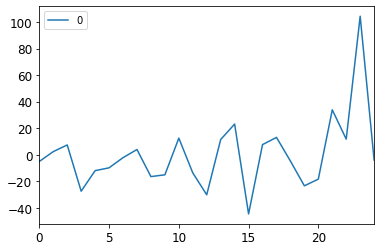

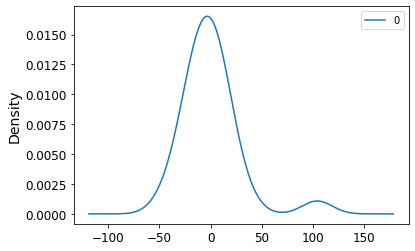

                0
count   25.000000
mean     0.192808
std     27.993501
min    -44.531310
25%    -15.098217
50%     -3.992989
75%     11.466241
max    104.300136


In [44]:
from statsmodels.tsa.arima_model import ARIMA
 
model = ARIMA(test, order=(5,1,0))
model_fit = model.fit(disp=0)

#print(model_fit.summary())

# plot residual errors: residual of an observed value is 
# the difference between the observed value and the estimated value of the quantity of interest 
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

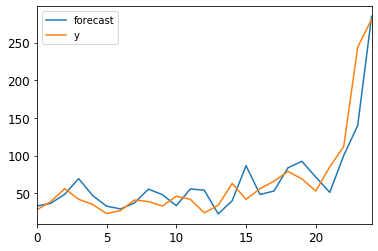

In [45]:
model_fit.plot_predict(dynamic=False)

plt.show()




test MSE: 89.107


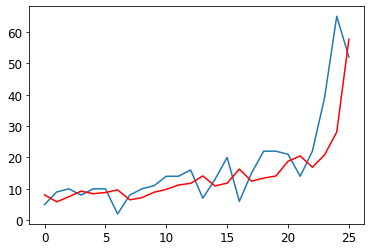

In [46]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
 
X = topic_1.values
size = int(len(X) * 0.75)   # Split percentage

train, Topic_1 = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(Topic_1)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = Topic_1[t] # you forecast the next "point" continuosly
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(Topic_1, predictions)
print('test MSE: %.3f' % error)
# plot
plt.plot(Topic_1)
plt.plot(predictions, color='red')

plt.show()




In [48]:
error = mean_absolute_error(test, predictions)
error


50.51127338864659